In [1]:
# Loading MNIST object from Scikit-Learn

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets from Scikit-Learn has the same dictionary structure:
* a 'DESCR' key describing the dataset
* a 'data' key containing an array with one row per instance and one column per feature
* a 'target' key containing an array with the labels

In [2]:
# Reading in the MNIST data

X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


There are 70,000 images and each image has 784 features (28x28 pixels). Each pixel ranges from 0 (white) to 255 (black).

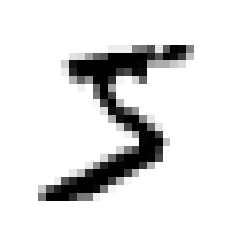

In [3]:
# Viewing one of the images

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
# Casting labels from string to integers

import numpy as np

y = y.astype(np.uint8)

In [5]:
# Splitting data into train and test set because data is already shuffled

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

Simplifing problem to detect if image is a 5 or not 5.

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### Stochastic Gradient Descent (SGD)
* trains observations one at a time
* great for online learning

In [7]:
### Implementing Stochastic Gradient Descent

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
# Predicting on image

sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

#### Measuring Accuracy Using Cross-Validation


*   StratifiedKFold: peforms stratifieed sampling to produce folds that contain a representative ratio of each class 
*   Scikit-Learn's cross_val_score()



In [9]:
# Implementing cross_val_score()

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

The accuracy looks great! Now we have to examine the results. One way to do it is to create a "dummy" classifier. In this case, we will create a classifier that always predicts that an image is NOT a 5.

In [10]:
# Creating a model class that predicts 0's

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  
  def fit(self, X, y=None):
    pass

  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [11]:
# Implementing the dummy classifier

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Based on the dummy classifier, predicting not a 5 gives an accuracy of 90%. This is because 10% of the data is only 5's. The data is skewed.
* skewed datasets: when some classes are much more frequent than others

#### Confusion Matrix
* alternative to evaluating performance of a classifier
* counts the number of times instances of class A are classified as class B and vice versa.

cros_val_predict()
* performs K-fold
* returns the predictions made on each test fold

In [12]:
# Predicting using the trained model

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix()
* each row represents an actual class
* each column represents a predicted class

In [13]:
# Using confusion matrix to anaylze the predictions

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The first row consists of non-5 images (negative class)
* 53,057 were correctly classified as non-5's (true negatives)
* 1,522 were incorrectly classified as 5's (false positives)

The second row considers images of 5's (positive class)
* 1,325 were wrongly classified as non-5's (false negatives)
* 4096 were correctly classified as 5s (true positives)

Precision: accuracy of the positive predictions (TP/(TP+FP))

Recall: ratio of positive instances that are correctly detected by the classifier (TP / (TP + FN))
*  also called: sensitivity or true positive rate

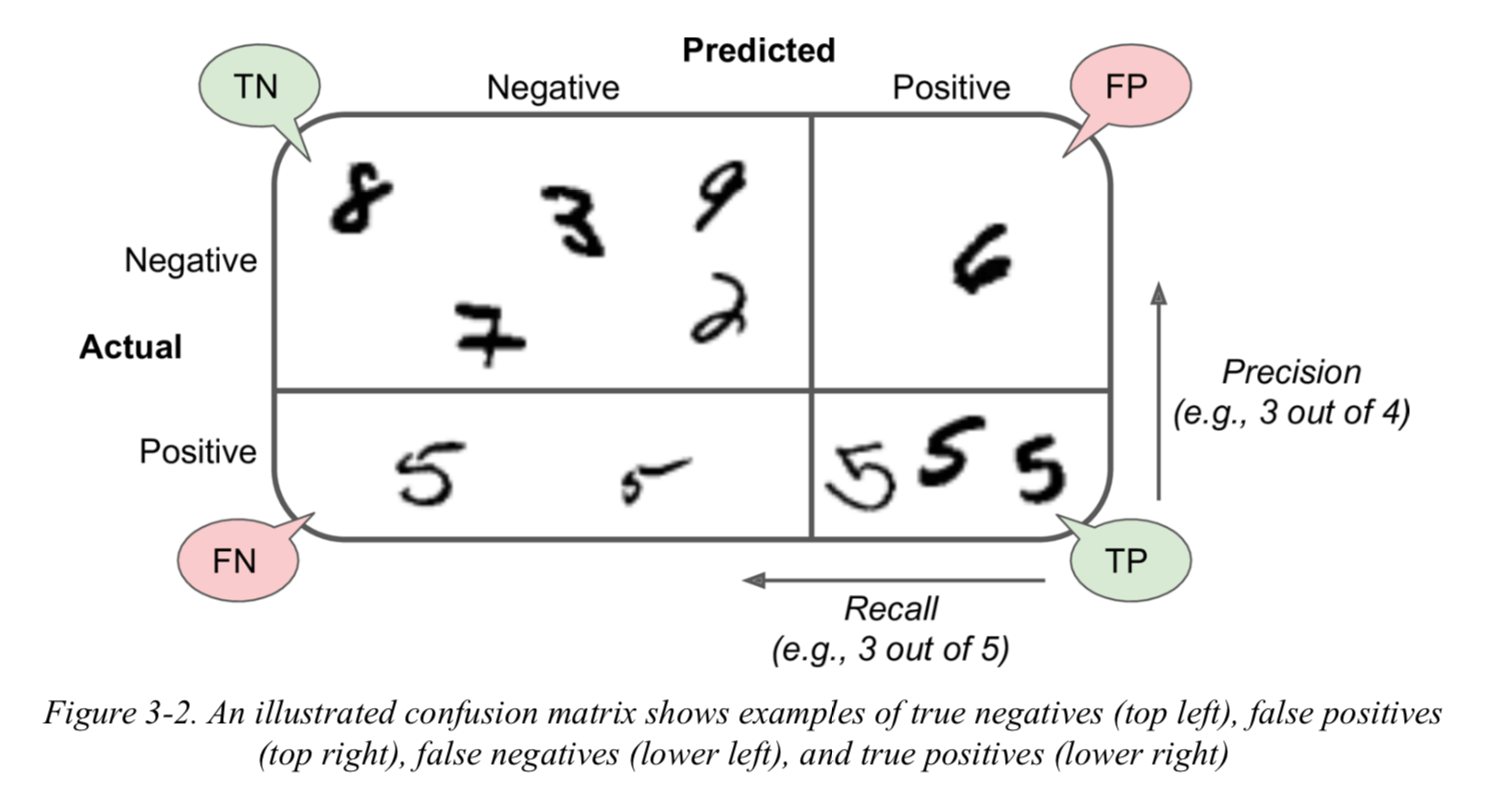

In [14]:
# Calculating precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* The precision is telling us that when it predicts an image to be a 5, it is correct 72.9% of the times
* The recall is telling us that it only predicts 5's 75.6% of the time.

F1 score: metric that combines precision and recall
* uses harmonic mean: gives weight to low values
* high F1 score -> high precision and recall

In [15]:
# Calculating F1 score

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

KNOW YOUR TASK AT HAND! Sometimes it you might only care about precision and other times you only care about recall.

#### Precision/Recall Trade-Off
A classifier computes a score based on a decision function. If the score s greater than a threshold, it assigns instance to the positive class. If it is less than threshold, it assigns the negative class. This decision threshold controls the trade-off between precision and recall.

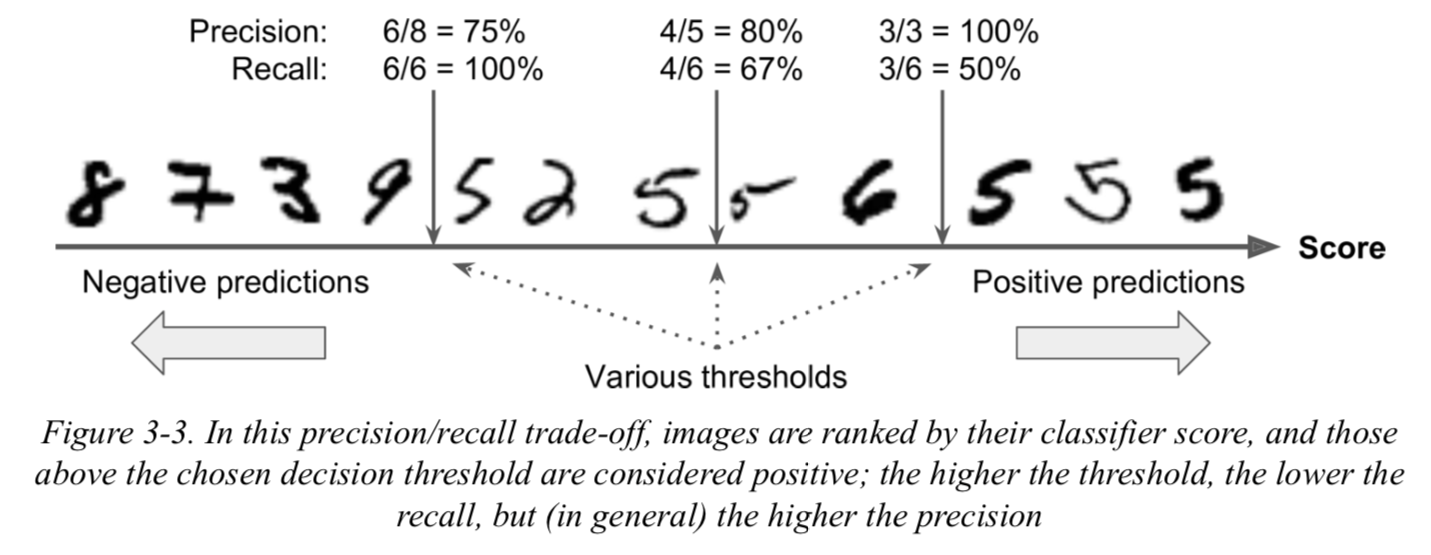

To set the threshold, call **decision_function()** method on the classifier. The default threshold for SGDClassifier is 0.

In [16]:
# Setting the decision threshold to 0 (default)

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)

[2164.22030239]


In [17]:
# Setting decision threshold to 8000

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use?
* Use **cross_val_predict()** and set method="decision_function" to return decision scores instead of predictions
* Use **precision_recall_curve** to compute precision and recall for all possible thresholds 

In [18]:
# Calculating precision and recall for all possible thresholds

from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

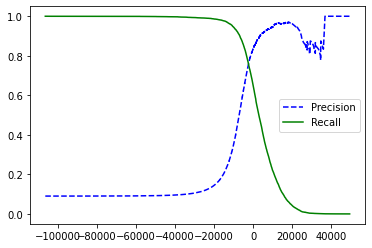

In [19]:
# Plotting the precisions, recalls, and thresholds

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to determine the threshold is to plot recall against precision and see what threshold fits our task. If we need a precision of 90%, we can look at the graph and see what threshold we need to give us that precision.

Text(0, 0.5, 'Precision')

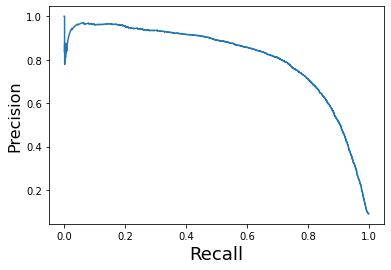

In [20]:
# Plotting Recall vs Precision

plt.plot(recalls, precisions)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=16)

In [21]:
# Setting threshold to give 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(f"Precision: {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred_90)}")

Precision: 0.9000345901072293
Recall: 0.4799852425751706


#### ROC Curve (Receiver Operating Characteristic)
* another common tool used for binary classification
* plots true positive rate (TPR) (RECALL) against the false positive rate (FPR)
* FPR: the ratio of negative instances that are incorrectly classified as positive
* FPR = 1 - true negative rate (TNR): ratio of negative instances that are correctly classified as negative
* TNR == specificity
* ROC curve plots sensitivity (recall) versus 1 - specificity

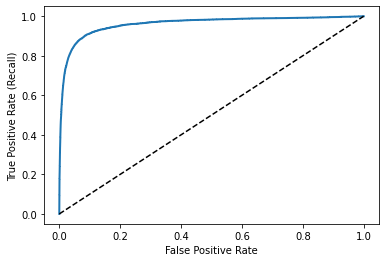

In [22]:
# Plotting ROC curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate (Recall)')
  plt.plot([0,1], [0,1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

##### AUC (area under the curve)
* is used to compare classifiers
* perfect classifier will have a ROC AUC of 1
* a random classifier will have a ROC AUC of 0.5

In [23]:
# Implementing ROC AUC

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### RoT: PR vs ROC curve
Use PR curve when positive class is rare or when we care more about the dalse positives than the the false negatives

#### Implementing Random Forest
* use predict_proba() instead of decision_function()
* returns array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class

In [24]:
# Fitting a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

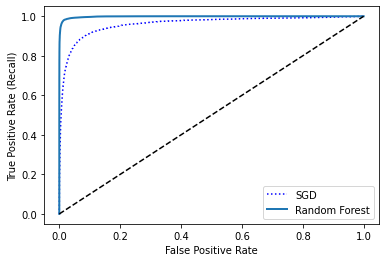

In [25]:
# Plotting the ROC curves

y_scores_forest = y_probs_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
# Calculating AUC

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Random Forest ROC curve and AUC is better than SGD

### Multiclass Classification
* multinommial classifiers
* One-Versus-the-Rest (OvR)
* train as many binary classifiers as there are classes and choose the class based on the highest output score
* Scikit automatically does this for us

In [27]:
# Implementing SVC

from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [28]:
# Getting the scores

some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5


In [29]:
# # Choosing a One-vs-Rest Classifier

# from sklearn.mulitclass import OneVsRestClassifier

# ovr_clf = OneVsRestClassifier(SVC())
# ovr_clf.fit(X_train, y_train)
# ovr_clf.predict([some_digit])

ModuleNotFoundError: ignored

In [31]:
# Fitting regular SGDClassifiers for Multiclass

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [32]:
# Viewing the values for each class in decision_function()

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [33]:
# Getting CV score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [34]:
# Getting CV score AFTER scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)

array([0.8983, 0.891 , 0.9018])

### Error Analysis
* In real project follow ML project checklist (explore data preparation options, try multiple models, automate)
* once a model is selected, analyze the types of errors it makes

In [35]:
# Viewing the confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

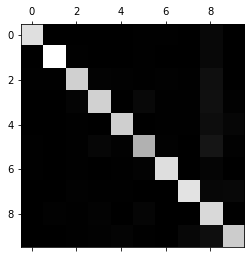

In [37]:
# Viewing the image representation of confusion matrix

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* Most images are on the main diagnol, which means they were classified correctly.
* the 5's look slightly darker. Either there were few 5's in the dataset or classifier did not perform well

In [38]:
# Converting counts in confusion matrix into a percentage of errors by dividing by number of images

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

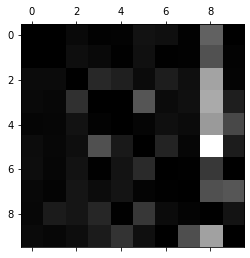

In [40]:
# Fill diagnol with zeros to keep only the errors

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows are actual class and columns are predictions. We can see the kinds of errors the classifier makes. 
* column for class 8 is bright: many images get misclassified as 8s.
* row for class 8 is pretty dark: actual 8's are properly classified
* 3's and 5's get confused

Possible Solutions for the misclassified as 8's:
* get more images that look like 8 but are not
* engineer a new feature that counts loops
* preprocess images to make loops stand out more

In [ ]:
 # Viewing some 3's and 5's to get more insights on why it was misclassified

cl_a, cl_b = 2, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


Some 3's and 5's are written badly but there are some obvious ones that should not be misclassified. One reason is the simple SGDClassifier. SGD assigns a weight per class on each pixel and when it sees new images, it sums up the weighted pixel intensities. Since 3's and 5's differ by a few pixels, it can confuse them.

### Multilabel Classification
have multiple labels for an observation 

In [41]:
# Creating a y_multilabel array containing two target labels for each digit image (>=7 and odd)

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [42]:
# Predicting

knn_clf.predict([some_digit])

array([[False,  True]])

In [43]:
# Calculating the F1 score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

KeyboardInterrupt: ignored

In some tasks, not all classes are equally important When some classes needs to be weighted, set average = "weighted"

### Multioutput Classification
* each label can be multiclass
* generalization of multilabel classification

In [ ]:
# Adding noise to MNIST

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0 , 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# Classifying using KNN

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)